<a href="https://colab.research.google.com/github/HugoKD/NLP/blob/main/similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from transformers import BertTokenizer, BertModel
import torch
import tensorflow as tf
from transformers import T5Tokenizer, T5ForConditionalGeneration
from sentence_transformers import SentenceTransformer, losses

import torch
import torch.nn as nn
from sentence_transformers import losses
from transformers import AutoTokenizer, AutoModel

In [ ]:
from tqdm import tqdm
from torch.utils.data import DataLoader

In [ ]:
pip install transformers sentencepiece

## EDA

In [ ]:
print(len(data))

499


In [ ]:
print(type(data[0]))

<class 'dict'>


In [ ]:
print(data[0].keys())

dict_keys(['anchor', 'query', 'positive', 'negative'])


In [ ]:
for i,t in enumerate(data) :
  if t["anchor"].lower().find('invention') == -1 :
    if t["anchor"].lower().find('TECHINCAL FIELD'.lower()) == -1:
      if t["anchor"].lower().find('TECHNICAL FIELD'.lower()) == -1:
        print(i,t["anchor"].lower().find('Disclosure'.lower()))



349 31
350 31
392 258
429 355
445 185
446 185


In [ ]:
for i, t in enumerate(data): #preference : invention, Technical Field, TECHINCAL FIELD, disclosure,This application
  point = (t["anchor"].lower().find('technical field'),t["anchor"].lower().find('TECHINCAL FIELD'.lower()),t["anchor"].lower().find('invention'))
  if point == (-1,-1,-1):
    print(i,t)

349 {'anchor': 'BACKGROUND [0001] Field of the Disclosure [0002] The present disclosure is directed toward a toolbar hinge for an agricultural implement. [0003] Description of the Related Art [0004] The continued need to improve upon the prior art in the field of agricultural implements has resulted in the introduction of a number of folding toolbars, able to be placed in multiple positions to accommodate both operational and transportation requirements. [0005] The art continues to be developed with the aim of improving capabilities of the implements while operating in the field optimizing stability of the implements when in a working position and in a transport position. [0006] Many agricultural implements require lockdown pins to prevent or reduce unintended motion of articulating toolbars as the agricultural implements traverse uneven surfaces or hard to penetrate soils. The positioning of the toolbar on the back of the tractor places a heavy load on the tractor, leading to non-idea

## Prepro

In [ ]:
data = pd.DataFrame(data)

In [ ]:
def truncate(row):
    row_lower = row.lower()
    point = next((p for p in (
        row_lower.find('technical field'),
        row_lower.find('invention'),
        row_lower.find('disclosure'),
        row_lower.find('this application')
    ) if p != -1), None)

    if point is not None:
        return row[point:]
    else:
        print("No match found in:", row)
        return None

data['prepro_anchor'] = data['anchor'].apply(truncate)

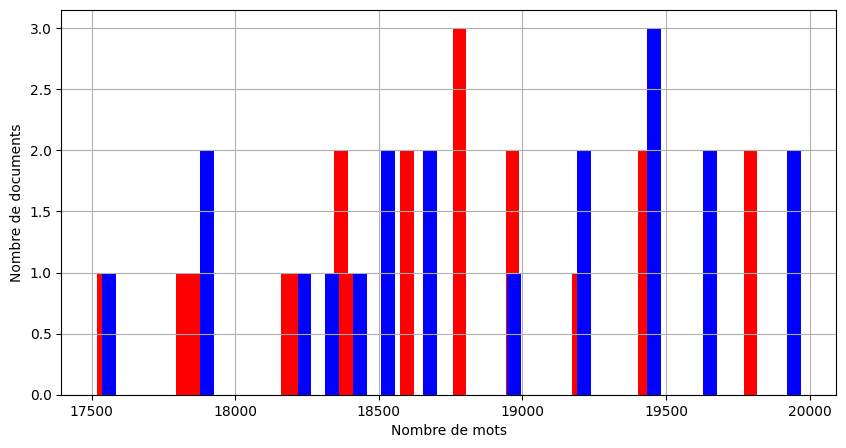

In [ ]:
l_prepro,l  = data['prepro_anchor'].apply(lambda x : len(x)),data['anchor'].apply(lambda x : len(x))
plt.figure(figsize=(10, 5))
plt.hist(l_prepro, bins=50, color= 'red')
plt.hist(l, bins=50, color = 'blue')

plt.xlabel("Nombre de mots")
plt.ylabel("Nombre de documents")
plt.grid(True)
plt.show()

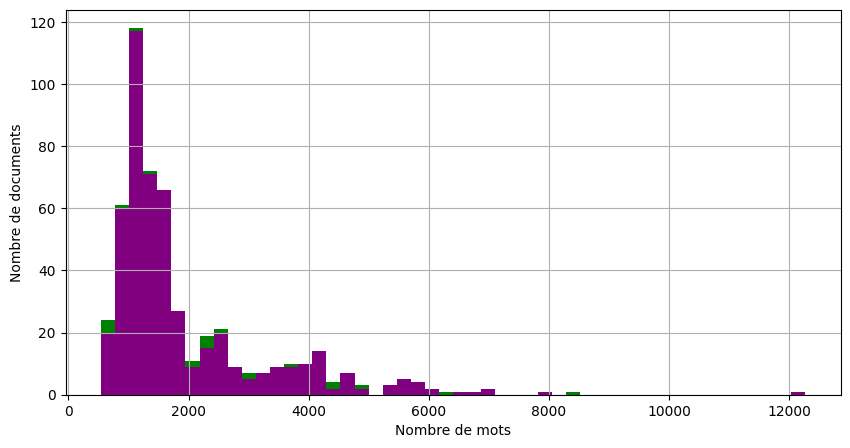

In [ ]:
l_prepro,l  = data['positive'].apply(lambda x : len(x)),data['negative'].apply(lambda x : len(x))
plt.figure(figsize=(10, 5))
plt.hist(l_prepro, bins=50, color= 'green')
plt.hist(l, bins=50, color = 'purple')

plt.xlabel("Nombre de mots")
plt.ylabel("Nombre de documents")
plt.grid(True)
plt.show()

## Test avec la concaténation :

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model_name = "bert-base-uncased"
bert_tokenizer = BertTokenizer.from_pretrained(model_name)
bert = BertModel.from_pretrained(model_name)

bert = bert.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
#generate a response of our query given the anchor
tokenizer = T5Tokenizer.from_pretrained('t5-small')
model = T5ForConditionalGeneration.from_pretrained('t5-small')

T5 = model.to(device)

### Some other lil tests

In [ ]:
def get_bert_embedding(text,bert):

    tokens = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
    bert.to(device)
    tokens = {key: value.to(device) for key, value in tokens.items()}
    with torch.no_grad():
        outputs = bert(**tokens)

    sentence_embedding = outputs.last_hidden_state[:, 0, :]
    return sentence_embedding.cpu().numpy()

In [ ]:
def generate_T5(row):
  inputs = tokenizer(row, return_tensors="pt", padding=True,max_length=512).to(device)
  output = T5.generate(
      **inputs,
      num_beams=4,
      max_length = 512,
      early_stopping=True
  )
  response = tokenizer.decode(output[0], skip_special_tokens=True)
  print(row)
  return response

In [ ]:
data = data[:20]

In [ ]:
data['inputs'] = "Question : " + data['query'] + 'Context : ' + data['prepro_anchor']

<ipython-input-67-d54791602472>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['inputs'] = "Question : " + data['query'] + 'Data : ' + data['prepro_anchor']


In [ ]:
generate_T5(data.iloc[0]['inputs'])

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Question : What are the key advantages and applications of an implantable stimulator system that uses a passive magnetostrictive electroactive sensor for power harvesting in a non-vibration rich environment?,Data : INVENTION This invention relates to apparatus and methods for harvesting energy from the environment and other sources external to the harvester and converting it to useful electrical energy. The present invention generally relates to implantable stimulator systems and methods, and more particularly relates to implantable stimulator systems and methods utilizing one or more implantable microstimulators for direct electrical current. Specifically outlined is the use of PME for the delivery of microstimulation through applied external magnetic field technology. The delivered therapy will be effective for continuous or temporary, as needed (PRN) therapeutic intervention. BACKGROUND OF THE INVENTION Energy harvesters are known that convert vibrational energy into electrical ener

'is a small implantable device that uses a passive magnetostrictive/electroactive (PME) magnetic field sensor. the device is preferably a layered structure (e.g., sandwich) of magnetostrictive material having a magnetization vector. the sensing element is rigidly attached to an object that moves relative to the applied field. the sensing element is stationary with respect to a remote changing external magnetic field.'

In [ ]:
data.iloc[0]['query']

'What are the key advantages and applications of an implantable stimulator system that uses a passive magnetostrictive electroactive sensor for power harvesting in a non-vibration rich environment?,'

In [ ]:
data['respose'] = data['inputs'].apply(generate_T5)

Question : What are the key advantages and applications of an implantable stimulator system that uses a passive magnetostrictive electroactive sensor for power harvesting in a non-vibration rich environment?,Data : INVENTION This invention relates to apparatus and methods for harvesting energy from the environment and other sources external to the harvester and converting it to useful electrical energy. The present invention generally relates to implantable stimulator systems and methods, and more particularly relates to implantable stimulator systems and methods utilizing one or more implantable microstimulators for direct electrical current. Specifically outlined is the use of PME for the delivery of microstimulation through applied external magnetic field technology. The delivered therapy will be effective for continuous or temporary, as needed (PRN) therapeutic intervention. BACKGROUND OF THE INVENTION Energy harvesters are known that convert vibrational energy into electrical ener

In [ ]:
data.rename(columns={'respose':'response'},inplace=True)

In [ ]:
data['response_embedding'] = data['response'].apply(lambda x : get_bert_embedding(x,bert))

In [ ]:
response_embedding = tf.convert_to_tensor(data['response_embedding'].tolist())
response_embedding = tf.squeeze(response_embedding, axis=1)

positive_embedding = tf.convert_to_tensor(data["positive"])
negative_embedding = tf.convert_to_tensor(data["negative"])

In [ ]:
triplet_loss = losses.TripletLoss(model=model, distance_metric=losses.SiameseDistanceMetric.COSINE_DISTANCE, margin=0.3)
loss_value = triplet_loss.forward(response_embedding, positive_embedding, negative_embedding)

print("Triplet Loss:", loss_value.item())

# TODO : Implémenter une version end-to-end différentiable
## -> : inclure tous les calculs dans le graphe de calcul PyTorch pour permettre à la backpropagation
##de remonter à travers toute la chaîne, y compris la génération T5 et l'encodage BERT.
Aujourd'hui, seule la génération T5 est entraînée, et BERT est gelé (utilisé comme fonction de scoring externe).
Dans cette version future, on envisagerait :
   - soit d'intégrer l'encodage BERT au graphe pour éventuellement co-entraîner une fonction de scoring,
   - soit de remplacer l'étape de génération (non différentiable) par un mécanisme differentiable (ex : sampling continu / softmax différentiable),
   - soit d'utiliser une loss de type Reinforcement Learning (ex : REINFORCE ou reward-based learning) pour remonter la qualité d'une séquence générée,     même si elle passe par une étape non différentiable (comme decode + encode + score).

By including bert in the training loop, i feel like I’m drifting away from my initial goal, which is to generate a response that’s close to the positive example and far from the negative one. <br>


It feels like I’m artificially lowering the loss, since the model is also learning how to represent those elements better <br>
I was actually thinking of BERT more like an external evaluator, rather than something that’s truly part of the model being optimized.

#### BERT frozen version

In [ ]:
from torch.utils.data import Dataset

class TripletTextDataset(Dataset):
    def __init__(self, dataframe):
        self.anchors = dataframe['inputs'].tolist()
        self.positives = dataframe['positive'].tolist()
        self.negatives = dataframe['negative'].tolist()

    def __len__(self):
        return len(self.anchors)

    def __getitem__(self, idx):
        return {
            'anchor': self.anchors[idx],
            'positive': self.positives[idx],
            'negative': self.negatives[idx]
        }

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch
import json
import pandas as pd
from transformers import AutoTokenizer, BertModel, T5Tokenizer, T5ForConditionalGeneration
from tqdm import tqdm

class TripletTextDataset(Dataset):
    def __init__(self, dataframe):
        self.anchors = dataframe['inputs'].tolist()
        self.positives = dataframe['positive'].tolist()
        self.negatives = dataframe['negative'].tolist()

    def __len__(self):
        return len(self.anchors)

    def __getitem__(self, idx):
        return {
            'anchor': self.anchors[idx],
            'positive': self.positives[idx],
            'negative': self.negatives[idx]
        }

class CustomModel:
    def __init__(self, truncate=True, path='/content/dataset_big_patent_v3.json',
                 bert_model_name="bert-base-uncased", margin=0.3, device=None):

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu") if device is None else device

        self.tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
        self.bert = BertModel.from_pretrained(bert_model_name).to(self.device)

        self.t5_tokenizer = T5Tokenizer.from_pretrained("t5-small")
        self.T5 = T5ForConditionalGeneration.from_pretrained("t5-small").to(self.device)

        self.triplet_loss_fn = torch.nn.TripletMarginLoss(margin=margin, p=2)

        self.load_data(path)
        if truncate:
            self.data["anchor"] = self.data["anchor"].apply(self.truncate_text)

        self.data['inputs'] = 'question: ' + self.data['query'] + '\ncontext: ' + self.data['anchor']
        self.dataset = TripletTextDataset(self.data)

    def load_data(self, path):
        with open(path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        self.data = pd.DataFrame(data)

    def truncate_text(self, text):
        text_lower = text.lower()
        point = next((p for p in (
            text_lower.find('technical field'),
            text_lower.find('invention'),
            text_lower.find('disclosure'),
            text_lower.find('this application')
        ) if p != -1), None)
        return text[point:] if point is not None else text

    def get_embedding(self, text, requires_grad=False):
        tokens = self.tokenizer(text, padding=True, truncation=True, return_tensors="pt").to(self.device)
        if requires_grad:
            outputs = self.bert(**tokens)
        else:
            with torch.no_grad():
                outputs = self.bert(**tokens)
        return outputs.last_hidden_state[:, 0, :].squeeze(0)

    def fit(self, optimizer, batch_size=8, epochs=10):
        self.T5.train()
        self.bert.eval()
        dataloader = DataLoader(self.dataset, batch_size=batch_size, shuffle=True)

        for epoch in range(epochs):
            total_loss = 0.0
            print(f"\nEpoch {epoch + 1}/{epochs}")

            for batch in tqdm(dataloader, desc=f"Epoch {epoch + 1}"):
                input_texts = batch['anchor']
                tokenized = self.t5_tokenizer(input_texts, return_tensors="pt", padding=True, truncation=True).to(self.device)
                generated_ids = self.T5.generate(
                    **tokenized,
                    num_beams=4,
                    max_length=256,
                    early_stopping=True
                )
                generated_texts = [self.t5_tokenizer.decode(g, skip_special_tokens=True) for g in generated_ids]

                # Get anchor embeddings with grad
                anchor_emb = torch.stack([self.get_embedding(text, requires_grad=True) for text in generated_texts])

                # Get positive and negative embeddings without grad
                positive_emb = torch.stack([self.get_embedding(p) for p in batch['positive']])
                negative_emb = torch.stack([self.get_embedding(n) for n in batch['negative']])

                optimizer.zero_grad()
                loss = self.triplet_loss_fn(anchor_emb, positive_emb, negative_emb)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            mean_loss = total_loss / len(dataloader)
            print(f"Mean triplet loss for epoch {epoch + 1}: {mean_loss:.4f}")

        return mean_loss

In [ ]:
model = CustomModel(path='/content/dataset_big_patent_v3.json')
optimizer = torch.optim.AdamW(model.T5.parameters(), lr=5e-5)

In [ ]:
mtorch.cuda.empty_cache()

In [ ]:
model.fit(optimizer)


Epoch 1/10


Epoch 1: 100%|██████████| 63/63 [01:14<00:00,  1.19s/it]


Mean triplet loss for epoch 1: 0.9568

Epoch 2/10


Epoch 2: 100%|██████████| 63/63 [01:09<00:00,  1.10s/it]


Mean triplet loss for epoch 2: 0.9302

Epoch 3/10


Epoch 3: 100%|██████████| 63/63 [01:05<00:00,  1.05s/it]


Mean triplet loss for epoch 3: 0.9451

Epoch 4/10


Epoch 4: 100%|██████████| 63/63 [01:08<00:00,  1.08s/it]


Mean triplet loss for epoch 4: 0.9290

Epoch 5/10


Epoch 5: 100%|██████████| 63/63 [01:05<00:00,  1.05s/it]


Mean triplet loss for epoch 5: 0.9210

Epoch 6/10


Epoch 6: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


Mean triplet loss for epoch 6: 0.9488

Epoch 7/10


Epoch 7: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


Mean triplet loss for epoch 7: 0.9467

Epoch 8/10


Epoch 8: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


Mean triplet loss for epoch 8: 0.9434

Epoch 9/10


Epoch 9: 100%|██████████| 63/63 [01:07<00:00,  1.07s/it]


Mean triplet loss for epoch 9: 0.9256

Epoch 10/10


Epoch 10: 100%|██████████| 63/63 [01:07<00:00,  1.08s/it]

Mean triplet loss for epoch 10: 0.9450


0.9450472839294918

### Training T5 + BERT

Rq : .detach().cpu(). peut être utile pour stocker des éléments autre part que dans le gpu, et donc économiser de la mémoire pour des calculs vraiement utiles.

In [5]:
from torch.utils.data import Dataset

class TripletTextDataset(Dataset):
    def __init__(self, dataframe):
        self.anchors = dataframe['inputs'].tolist()
        self.positives = dataframe['positive'].tolist()
        self.negatives = dataframe['negative'].tolist()

    def __len__(self):
        return len(self.anchors)

    def __getitem__(self, idx):
        return {
            'anchor': self.anchors[idx],
            'positive': self.positives[idx],
            'negative': self.negatives[idx]
        }

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModel, T5Tokenizer, T5ForConditionalGeneration
from sklearn.metrics import accuracy_score
import json
import pandas as pd
from tqdm import tqdm

class CustomModel(nn.Module):
    def __init__(self, truncate=True, path='/content/dataset_big_patent_v3.json',
                 bert_model_name="bert-base-uncased", margin=0.3, device=None):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu") if device is None else device

        self.tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
        self.bert = AutoModel.from_pretrained(bert_model_name).to(self.device)

        self.t5_tokenizer = T5Tokenizer.from_pretrained("t5-small")
        self.T5 = T5ForConditionalGeneration.from_pretrained("t5-small").to(self.device)

        self.triplet_loss_fn = torch.nn.TripletMarginLoss(margin=margin, p=2)

        self.load_data(path)
        if truncate:
            self.data["anchor"] = self.data["anchor"].apply(self.truncate_text)

        self.data['inputs'] = 'question: ' + self.data['query'] + '\ncontext: ' + self.data['anchor']
        self.dataset = TripletTextDataset(self.data)

    def load_data(self, path):
        with open(path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        self.data = pd.DataFrame(data)

    def truncate_text(self, text):
        text_lower = text.lower()
        point = next((p for p in (
            text_lower.find('technical field'),
            text_lower.find('invention'),
            text_lower.find('disclosure'),
            text_lower.find('this application')
        ) if p != -1), None)
        return text[point:] if point is not None else text

    def get_embedding(self, text, requires_grad=True):
        tokens = self.tokenizer(text, padding=True, truncation=True, return_tensors="pt").to(self.device)
        if requires_grad:
            outputs = self.bert(**tokens)
        else:
            with torch.no_grad():
                outputs = self.bert(**tokens)
        return outputs.last_hidden_state[:, 0, :].squeeze(0)

    def fit(self, optimizer, batch_size=32, epochs=20):
        self.T5.train()
        self.bert.train()  # Enable training for BERT

        dataloader = DataLoader(self.dataset, batch_size=batch_size, shuffle=True)

        for epoch in range(epochs):
            total_loss = 0.0
            print(f"\nEpoch {epoch + 1}/{epochs}")

            for batch in tqdm(dataloader, desc=f"Epoch {epoch + 1}"):
                input_texts = batch['anchor']
                tokenized = self.t5_tokenizer(input_texts, return_tensors="pt", padding=True, truncation=True).to(self.device)
                generated_ids = self.T5.generate(
                    **tokenized,
                    num_beams=4,
                    max_length=512,
                    early_stopping=True
                )
                generated_texts = [self.t5_tokenizer.decode(g, skip_special_tokens=True) for g in generated_ids]

                # Get anchor embeddings with grad
                anchor_emb = torch.stack([self.get_embedding(text, requires_grad=True) for text in generated_texts])

                # Get positive and negative embeddings without grad
                positive_emb = torch.stack([self.get_embedding(p) for p in batch['positive']])
                negative_emb = torch.stack([self.get_embedding(n) for n in batch['negative']])

                optimizer.zero_grad()
                loss = self.triplet_loss_fn(anchor_emb, positive_emb, negative_emb)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()


                del tokenized, generated_ids, generated_texts
                del anchor_emb, positive_emb, negative_emb, loss
                torch.cuda.empty_cache()



            mean_loss = total_loss / len(dataloader)
            print(f"Mean triplet loss for epoch {epoch + 1}: {mean_loss:.4f}")

        return mean_loss

In [41]:
# Example usage:
model = CustomModel()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
model.fit(optimizer, batch_size=12, epochs=10)


Epoch 1/10


Epoch 1: 100%|██████████| 42/42 [01:55<00:00,  2.76s/it]


Mean triplet loss for epoch 1: 0.4061

Epoch 2/10


Epoch 2: 100%|██████████| 42/42 [01:55<00:00,  2.75s/it]


Mean triplet loss for epoch 2: 0.2618

Epoch 3/10


Epoch 3: 100%|██████████| 42/42 [01:54<00:00,  2.71s/it]


Mean triplet loss for epoch 3: 0.2202

Epoch 4/10


Epoch 4: 100%|██████████| 42/42 [01:54<00:00,  2.72s/it]


Mean triplet loss for epoch 4: 0.2254

Epoch 5/10


Epoch 5: 100%|██████████| 42/42 [01:52<00:00,  2.68s/it]


Mean triplet loss for epoch 5: 0.1724

Epoch 6/10


Epoch 6: 100%|██████████| 42/42 [01:54<00:00,  2.72s/it]


Mean triplet loss for epoch 6: 0.1802

Epoch 7/10


Epoch 7: 100%|██████████| 42/42 [01:54<00:00,  2.71s/it]


Mean triplet loss for epoch 7: 0.1814

Epoch 8/10


Epoch 8: 100%|██████████| 42/42 [01:54<00:00,  2.72s/it]


Mean triplet loss for epoch 8: 0.1545

Epoch 9/10


Epoch 9: 100%|██████████| 42/42 [01:53<00:00,  2.70s/it]


Mean triplet loss for epoch 9: 0.1810

Epoch 10/10


Epoch 10: 100%|██████████| 42/42 [02:00<00:00,  2.86s/it]

Mean triplet loss for epoch 10: 0.1542


0.15421155378932044

In [45]:
'''torch.save(model.T5.state_dict(), "t5_checkpoint_similarity_4elmts.pt")
torch.save({
    'epoch': 10,
    'model_state_dict': model.T5.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, 't5_checkpoint_full_similarity_4elmts.pt')'''

In [62]:
print(f"Memory used: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")

Memory used: 14415.86 MB


Evaluate it (on the train dataset too ... )

In [129]:
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
import numpy as np

def evaluate(model, batch_size=16, epochs=1):
    model.T5.eval()
    model.bert.eval()
    model.to(model.device)

    dataloader = DataLoader(model.dataset, batch_size=batch_size, shuffle=True)
    correct = 0

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")

        for batch in tqdm(dataloader, desc=f"Epoch {epoch + 1}"):
            with torch.no_grad():
                input_texts = batch['anchor']
                tokenized = model.t5_tokenizer(
                    input_texts,
                    return_tensors="pt",
                    padding=True,
                    truncation=True
                ).to(model.device)

                generated_ids = model.T5.generate(
                    **tokenized,
                    num_beams=4,
                    max_length=512,
                    early_stopping=True
                )

                generated_texts = [model.t5_tokenizer.decode(g, skip_special_tokens=True) for g in generated_ids]

                anchor_emb = torch.stack([
                    model.get_embedding(text).to(model.device)
                    for text in generated_texts
                ])

                positive_emb = torch.stack([
                    model.get_embedding(p).to(model.device)
                    for p in batch['positive']
                ])
                negative_emb = torch.stack([
                    model.get_embedding(n).to(model.device)
                    for n in batch['negative']
                ])

                # cosine_similarity shape: [batch_size]
                sim_pos = torch.nn.functional.cosine_similarity(anchor_emb, positive_emb, dim=1)
                sim_neg = torch.nn.functional.cosine_similarity(anchor_emb, negative_emb, dim=1)

                correct += (sim_pos > sim_neg).sum().item()

                del tokenized, generated_ids, generated_texts
                del anchor_emb, positive_emb, negative_emb
                torch.cuda.empty_cache()

    return correct / len(model.dataset)


In [130]:
evaluate(model)


Epoch 1/1


Epoch 1: 100%|██████████| 32/32 [00:59<00:00,  1.86s/it]


0.8196392785571143